<a href="https://colab.research.google.com/github/nuvard/kern_segmentation/blob/master/6_channel_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 6-channel transfer-learning

In [1]:
%%capture

from __future__ import print_function, division
from dataclasses import dataclass, replace
from pathlib import Path
from typing import Callable, List, Optional, Sequence, Union

import pandas as pd
import torch 
import os
from pandas import DataFrame
from PIL import Image
from torch.utils.data.dataloader import default_collate
import sklearn
import numpy as np
from matplotlib import pyplot as plt

import numpy as np
from torchvision import transforms

from torchvision import models
from torch.nn.modules import loss
from torch import optim
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torchvision.transforms.functional as TF
from tqdm.auto import tqdm

import os
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode
from torchvision.transforms import RandomVerticalFlip, RandomCrop

from albumentations import RandomCrop, Normalize, HorizontalFlip, Resize
from albumentations import Compose
from albumentations.pytorch import ToTensor


In [3]:
!pip install wandb

     |████████████████████████████████| 1.3MB 3.4MB/s eta 0:00:01
     |████████████████████████████████| 61kB 10.1MB/s eta 0:00:01
     |████████████████████████████████| 92kB 13.8MB/s eta 0:00:01
     |████████████████████████████████| 102kB 15.4MB/s ta 0:00:01
     |████████████████████████████████| 81kB 12.1MB/s eta 0:00:01
     |████████████████████████████████| 460kB 57.0MB/s eta 0:00:01
     |████████████████████████████████| 440kB 51.6MB/s eta 0:00:01
     |████████████████████████████████| 92kB 12.7MB/s eta 0:00:01
     |████████████████████████████████| 61kB 10.3MB/s eta 0:00:01
     |████████████████████████████████| 143kB 42.5MB/s eta 0:00:01
     |████████████████████████████████| 163kB 41.3MB/s eta 0:00:01
     |████████████████████████████████| 133kB 40.6MB/s eta 0:00:01
     |████████████████████████████████| 71kB 12.0MB/s eta 0:00:01
     |████████████████████████████████| 256kB 55.1MB/s eta 0:00:01
     |████████████████████████████████| 184kB 53.4MB/s eta 0:00:01
  C

  Created wheel for promise: filename=promise-2.2.1-cp36-none-any.whl size=21292 sha256=a94d5a579474e43039173cd79ac3bcaf30661e912007f6d121eb0db2f81758b2
  Stored in directory: /root/.cache/pip/wheels/92/84/9f/75e2235effae0e1c5a5c0626a503e532bbffcb7e79e672b606
Successfully built watchdog subprocess32 nvidia-ml-py3 gql psutil shortuuid pathtools promise


In [3]:
import wandb
wandb.init(project="kern")


W&B Run: https://app.wandb.ai/nuvard/kern/runs/6w1avcda

In [5]:
DEVICE = torch.device("cuda")

In [6]:
def test(device: str):
    torch.ones(1,2,3).to(device)

test(DEVICE)

In [7]:
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [8]:
IMAGE_SIZE = 128
BATCH_SIZE = 64
PATH = '/project/'


In [9]:
def apply_class(data, column, class_dict):
    data['class']=data[column].apply(lambda x:class_dict[x] if (x in class_dict) else x) 
    
    
def check(data):
    to_drop = []
    for i in data.index:
        img_name=data.loc[i, 'Folder']+'/data/'+str(data.loc[i, 'Id'])+'.jpeg'

        #plt.figure()

        if not os.path.isfile(os.path.join(path, img_name)):
            to_drop.append(i)
            print("No image " + img_name)
        #plt.show()
    if(len(to_drop)==0):
        print ("All is OK!")

    return data.loc[~data.index.isin(to_drop),]  


## Подготовка данных

### Загрузка таблиц

In [7]:
path = '/project/'

Все данные

In [7]:
data = pd.read_csv(PATH+'data.csv')

In [0]:
data.head()


,Folder,Id,Field,Well,CoringTop,CoringDown,CoringTopBind,CoringDownBind,CoreRecovery,PhotoTop,PhotoDown,PhotoType,LayerTop,LayerDown,Rock,Carbonate,Ruin,Saturation
0,Unload1,1000000,Field6,Well11,1957.1,1963.1,1958.3,1964.3,5.93,0.00,1.00,ДС,0.00,1.45,песчаник,не карбонатный,не разрушен,нефтенасыщенные
1,Unload1,1000001,Field6,Well11,1957.1,1963.1,1958.3,1964.3,5.93,0.00,1.00,УФ,0.00,1.45,песчаник,не карбонатный,не разрушен,нефтенасыщенные
2,Unload1,1000002,Field6,Well11,1957.1,1963.1,1958.3,1964.3,5.93,1.00,1.45,ДС,0.00,1.45,песчаник,не карбонатный,не разрушен,нефтенасыщенные
3,Unload1,1000003,Field6,Well11,1957.1,1963.1,1958.3,1964.3,5.93,1.00,1.45,УФ,0.00,1.45,песчаник,не карбонатный,не разрушен,нефтенасыщенные
4,Unload1,1000004,Field6,Well11,1957.1,1963.1,1958.3,1964.3,5.93,1.45,2.00,ДС,1.45,3.54,алевролит,не карбонатный,не разрушен,не опред.


Данные из скважин, разделённые на ДС и УФ

In [10]:
data_uf = pd.read_csv(PATH+'data_uf.csv', index_col=0)
data_dc = pd.read_csv(PATH+'data_dc.csv', index_col=0)

### Переопределение классов

Нам нужны не все классы, а только некоторые. Пока я подготовлю словари для переименования классов. 

In [13]:
satur_dict = {'не опред.': 0, 'нефтенасыщенные': 1,'битуминозный':2, 'продукт':3, 'пятнисто нефтенасыщенные': 4,'слабо нефтенасыщенные':5 }

In [0]:
satur_int_dict = {'oil':0, 'unknown':1}

In [0]:
rock_dict = {"с карбонатными обломками или конкрециями": "с карб. обломками или конкрециями", \
             "пересл. кремнисто-глинистой породы и аргиллита": "пересл. кремн.-глинист. породы и аргиллитa", \
             "пересл. песчаника и глины аргиллитоподобной" : "пересл. песчаника и глины аргиллитоподобн."}

In [0]:
carbon_dict = {"не карбонатный": 'no_carbon', 'с карбонатными обломками или конкрециями': 'part_carbon', 'слабокарбонатный': 'carbon', \
               'сильнокарбонатный': 'carbon', 'среднекарбонатный':'carbon', 'пятнисто карбонатный':'part_carbon', 'с примесью':'part_carbon'}

In [0]:
ruin_dict = {"не карбонатный": 'no_carbon', 'с карбонатными обломками или конкрециями': 'part_carbon', 'слабокарбонатный': 'carbon', \
               'сильнокарбонатный': 'carbon', 'среднекарбонатный':'carbon', 'пятнисто карбонатный':'part_carbon', 'с примесью':'part_carbon'}

In [0]:
data.Carbonate.value_counts()

не карбонатный                              778
слабокарбонатный                            216
с карбонатными обломками или конкрециями    198
среднекарбонатный                            92
сильнокарбонатный                            90
с примесью                                   40
Name: Carbonate, dtype: int64

In [0]:
data.Rock.value_counts()

песчаник                                750
алевролит                               308
пересл. песчаника, алевролита и глин    168
аргиллит                                 92
песчаник глинистый                       74
алевро-аргиллит                          18
глина                                     4
Name: Rock, dtype: int64

In [0]:
data.Ruin.value_counts()

не разрушен          1172
частично разрушен     230
разрушен               12
Name: Ruin, dtype: int64

In [0]:
satur_dict

{'битуминозный': 'oil',
 'не опред.': 'unknown',
 'нефтенасыщенные': 'oil',
 'продукт': 'oil',
 'пятнисто нефтенасыщенные': 'oil',
 'слабо нефтенасыщенные': 'oil'}

Я подготовила функцию для ьыстрой замены классов.

In [0]:
apply_class(data,'Saturation', satur_dict)

In [16]:
apply_class(data_uf,'Saturation', satur_dict)
apply_class(data_dc,'Saturation', satur_dict)

### Проверка

Проверка актуальности таблицы

In [0]:
data = data.loc[~data.index.isin(to_drop),]

In [0]:
temp=check(data)


All is OK!


In [0]:
to

In [0]:
check(data_uf)

All is OK!


,Folder,Id,Field,Well,CoringTop,CoringDown,CoringTopBind,CoringDownBind,CoreRecovery,PhotoTop,PhotoDown,PhotoType,LayerTop,LayerDown,Rock,Carbonate,Ruin,Saturation,class
1,Unload1,1000001,Field6,Well11,1957.1,1963.1,1958.3,1964.3,5.93,0.00,1.00,УФ,0.00,1.45,песчаник,не карбонатный,не разрушен,нефтенасыщенные,0
3,Unload1,1000003,Field6,Well11,1957.1,1963.1,1958.3,1964.3,5.93,1.00,1.45,УФ,0.00,1.45,песчаник,не карбонатный,не разрушен,нефтенасыщенные,0
5,Unload1,1000005,Field6,Well11,1957.1,1963.1,1958.3,1964.3,5.93,1.45,2.00,УФ,1.45,3.54,алевролит,не карбонатный,не разрушен,не опред.,1
7,Unload1,1000007,Field6,Well11,1957.1,1963.1,1958.3,1964.3,5.93,2.00,3.00,УФ,1.45,3.54,алевролит,не карбонатный,не разрушен,не опред.,1
9,Unload1,1000009,Field6,Well11,1957.1,1963.1,1958.3,1964.3,5.93,3.00,3.54,УФ,1.45,3.54,алевролит,не карбонатный,не разрушен,не опред.,1
11,Unload1,1000011,Field6,Well11,1957.1,1963.1,1958.3,1964.3,5.93,3.54,4.00,УФ,3.54,5.85,песчаник,не карбонатный,не разрушен,слабо нефтенасыщенные,0
13,Unload1,1000013,Field6,Well11,1957.1,1963.1,1958.3,1964.3,5.93,4.00,5.00,УФ,3.54,5.85,песчаник,не карбонатный,не разрушен,слабо нефтенасыщенные,0
15,Unload1,1000015,Field6,Well11,1957.1,1963.1,1958.3,1964.3,5.93,5.00,5.85,УФ,3.54,5.85,песчаник,не карбонатный,не разрушен,слабо нефтенасыщенные,0
17,Unload1,1000017,Field6,Well11,1957.1,1963.1,1958.3,1964.3,5.93,5.85,5.93,УФ,5.85,5.93,"пересл. песчаника, алевролита и глин",не карбонатный,не разрушен,пятнисто нефтенасыщенные,0
19,Unload1,1000019,Field6,Well11,1963.1,1978.1,1964.3,1979.3,15.00,0.00,1.00,УФ,0.00,1.26,песчаник,не карбонатный,не разрушен,слабо нефтенасыщенные,0


## Создание датасета

2 статьи на хабре: от[ snakers4](https://habr.com/ru/post/349068/) и [ternaus](https://habr.com/ru/company/ods/blog/330118/).

Гитхаб: [snakers4](https://github.com/snakers4/spacenet-three), [pretrained resnet with fast.ai for proteins](https://www.kaggle.com/iafoss/pretrained-resnet34-with-rgby-0-460-public-lb)


In [11]:
def pil2tensor(image1, image2):
    "Convert PIL style `image` array to torch style image tensor."
    print('pil2tensor')
    image2 = image2.resize(image1.size)
    a = torch.from_numpy(np.asarray(image1))
    b = torch.from_numpy(np.asarray(image2))
    concated = torch.cat((a,b),-1)
    return concated


Transform = Callable[[Image.Image], Image.Image]

def show_batch_image(image_batch, batch_size=4, name='out.png', a = 0, b = 3 ):
    """
    Show a sample grid image which contains some sample of test set result
    :param image_batch: The output batch of test set
    :param a: - first channel to draw
    :param b: - (b-1) is last channel to draw
    :return: PIL image of all images of the input batch
    """
    print('show!')
    #inv_normalize = transforms.Normalize(
    #mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    #std=[1/0.229, 1/0.224, 1/0.255])
    
    to_pil =  transforms.ToPILImage()
    fs = []
    for i in range(batch_size):
        img = to_pil(image_batch.images[i,a:b,:,:].cpu())
        fs.append(img)
    x, y = fs[0].size
    ncol = int(np.ceil(np.sqrt(batch_size)))
    nrow = int(np.ceil(np.sqrt(batch_size)))
    cvs = Image.new('RGB', (x * ncol, y * nrow))
    for i in range(len(fs)):
        px, py = x * int(i / nrow), y * (i % nrow)
        cvs.paste((fs[i]), (px, py))
    #print(name)
    cvs.save(name, format='png')
    #cvs.show()
    plt.imshow(np.asarray(cvs))

    

@dataclass()
class ItemsBatch:
    images: torch.Tensor
    labels: torch.Tensor
    ids: List[int]
    paths: List[Path]
    items: List["DatasetItem"]


@dataclass()
class DatasetItem:
    image: Union[torch.Tensor, Image.Image]
    label: int
    id: int
    path: Path

    @classmethod
    def collate(cls, items: Sequence["DatasetItem"]) -> ItemsBatch:
        if not isinstance(items, list):
            items = list(items)
            #print(default_collate([item.label for item in items]))
        return ItemsBatch(
            images=default_collate([item.image for item in items]),
            
            labels=default_collate([item.label for item in items]),
            ids=[item.id for item in items],
            paths=[item.path for item in items],
            items=items,
        )

In [12]:
class KernDataset(Dataset):
    """Kern dataset."""

    def __init__(self, csv_file_dc,csv_file_uf, root_dir, transform=None, acc=0.2):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.acc = acc
        self.data_uf = pd.read_csv(csv_file_uf)
        self.labels_path = csv_file_uf
        self.root_dir = root_dir
        self.transform = transform
        self.data_dc = pd.read_csv(csv_file_dc)
    
    def __len__(self):
        return len(self.data_uf)
    """
    def transform(self, image, mask):
        #print(image.size)
        # Random crop      
        
        #print('resize')
        # Resize
        resize = transforms.Resize(size=(128, 128))
        image = resize(image)
        mask = resize(mask)
        #print('flip')
        # Random horizontal flipping
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)
        #print('to_tensor')
        # Transform to tensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        return image, mask
      """ 
    def __getitem__(self, idx):
        #print('idx '+str(idx))
        dc_img_name = os.path.join(self.root_dir,
                                self.data_dc.loc[idx, 'Folder']+'/data/'+str(self.data_dc.loc[idx, 'Id'])+'.jpeg')
        
        uf_img_name = os.path.join(self.root_dir,
                                self.data_uf.loc[idx, 'Folder']+'/data/'+str(self.data_uf.loc[idx, 'Id'])+'.jpeg')
        
        layer_width = self.data_dc.loc[idx, "LayerDown"] - self.data_dc.loc[idx, "LayerTop"]
        image_dc = Image.open(dc_img_name)
        image_uf = Image.open(uf_img_name).resize(image_dc.size)
        
        crop_size = min(image_dc.size[1], int(image_dc.size[1]*(self.acc/layer_width))-1)
        
        image_np = np.concatenate((np.array(image_dc),np.array(image_uf)), axis=-1)
        
        transf = RandomCrop( crop_size,image_dc.size[0] )
        image_np = transf(image=image_np)['image']
        
        if (crop_size<IMAGE_SIZE):
            transf = Resize(IMAGE_SIZE, int(image_dc.size[0]*(IMAGE_SIZE/crop_size)+1))
            image_np = transf(image=image_np)['image']
        augmented = self.transform(image = image_np)['image']
        augmented = torch.from_numpy(np.moveaxis(augmented / (255.0 if augmented.dtype == np.uint8 else 1), -1, 0).astype(np.float32))
        
        label = self.data_dc.loc[idx, 'class']
        #print(label)
        #sample = {'image': image, 'class_name': label}
        return DatasetItem(image=augmented, label=label, id=idx, path=dc_img_name)

Делю датасет на трейн и тест

In [13]:
validation_split = .2
shuffle_dataset = True
random_seed= 42

dataset_size = len(data_uf)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)


In [14]:
"""

transform = transforms.Compose(
    [
        #transforms.RandomRotation((5)),
        transforms.RandomResizedCrop((128,128)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
    ]
)

"""

def strong_aug(p=0.5):
    return Compose(
      [ RandomCrop(IMAGE_SIZE, IMAGE_SIZE, p=1),
        HorizontalFlip(p=p),
        Normalize([0.4802, 0.4481, 0.3975, 0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262,0.2302, 0.2265, 0.2262])
      ], 
    )

transform = strong_aug(p=0.5)


dataset = KernDataset(csv_file_uf=PATH+'data_uf.csv',csv_file_dc=PATH+'data_dc.csv',
                                    root_dir=PATH, transform = strong_aug(p=0.5))

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
#train_dataset_dc, test_dataset_dc = torch.utils.data.random_split(dataset_dc, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    collate_fn=DatasetItem.collate,
    num_workers=4
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=True,
    collate_fn=DatasetItem.collate,
    num_workers=4
)


In [15]:
dataset[0].image.shape

torch.Size([6, 128, 128])

In [16]:
temp = next(iter(train_loader))

show!


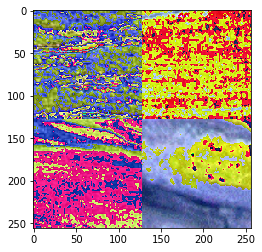

In [17]:
show_batch_image(temp, a=0, b=3)


show!


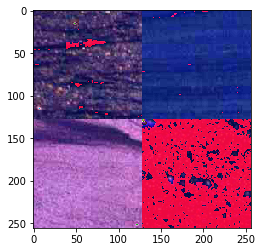

In [18]:

show_batch_image(temp,a = 3,b = 6)


In [0]:
(next(iter(train_loader_dc)).labels)

tensor([1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,
        0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1])

## Обучение модели 


In [19]:
from tqdm import tqdm_notebook

In [21]:
wandb.config.input_size = 128
wandb.config.output_size = 6

In [34]:
wandb.config.name = "6chan-transfer"

In [30]:
from sklearn.metrics import f1_score
def train(model, device, train_loader, optimizer, loss_function, epoch):
    print('begin!')
    model.train()
    model.to(device)
    correct = 0
    best_f1 = 0
    for idx, batch_data in enumerate(tqdm(train_loader)):
        data, target = batch_data.images.to(device), batch_data.labels.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        if (idx==0):
            preds=pred.flatten()
            targets=target
        else:
            preds = torch.cat((preds, pred.flatten()),0)
            targets = torch.cat((targets, target),0)
        correct += pred.eq(target.view_as(pred)).sum().item()
    f1 = f1_score(preds.detach().cpu().numpy(), targets.detach().cpu().numpy(), average="macro") 
    wandb.log({'Epoch': epoch, 'Train loss': loss.item(), 'F1': f1})
    if (f1>best_f1):
        wandb.run.summary["Best train f1"] = f1
        wandb.run.summary["epoch"] = epoch
        best_f1 = f1
        
    print(
        "Train Epoch: {}  [Accuracy: ({:.0f}%)] \tLoss: {:.6f}    F1: {:.4f}".format(
            epoch, 100.0 * correct / len(train_loader.dataset), loss.item(), f1
        )
    )
    
    
def test(model, device, test_loader, loss_function, epoch):
    model.eval()
    model.to(device)
    test_loss = 0
    correct = 0
    example_images = []
    with torch.no_grad():
        for idx, batch_data in enumerate(tqdm(test_loader)):
            data, target = batch_data.images.to(device), batch_data.labels.to(device)
            output = model(data)
            test_loss += loss_function(output, target).sum().item()
            pred = output.argmax(dim=1, keepdim=True)
            if (idx==0):
                preds=pred.flatten()
                targets=target
            else:
                preds = torch.cat((preds, pred.flatten()),0)
                targets = torch.cat((targets, target),0)
            correct += pred.eq(target.view_as(pred)).sum().item()
            example_images.append(wandb.Image(data[0][0:3,:,:].detach().cpu().numpy(), caption="Pred: {} Truth: {}".format(pred[0].item(), target[0])))

    test_loss /= len(test_loader.dataset)
    f1 = f1_score(preds.detach().cpu().numpy(), targets.detach().cpu().numpy(), average="macro")
    wandb.log({'Epoch': epoch, 'Test loss': test_loss.item(), 'F1': f1})
    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%) F1: {:.4f}\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
            f1
        )
    )

In [24]:
len(data_uf['class'].value_counts())

6

Пока я создаю базовые модельки. 
Я постараюсь делать всё по гайду https://karpathy.github.io/2019/04/25/recipe/.

In [25]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 6)
#print(model)
temp = model.conv1.weight
model.conv1 = nn.Conv2d(6, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.conv1.weight = nn.Parameter(torch.cat((temp,temp),dim=1))
print(model.conv1.weight.size())
#torch.nn.init.xavier_uniform_(model_dc.fc.bias)
#with torch.no_grad():
#  model_dc.fc.bias = nn.Parameter(torch.Tensor([0.5, 0.5]))
 
model = model.to(DEVICE)

optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

loss_function = loss.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 109MB/s] 


torch.Size([64, 6, 7, 7])


In [31]:
import datetime

In [32]:
current_time = str(datetime.datetime.now().timestamp())
train_log_dir = 'logs/tensorboard/train/' + current_time
log_dir = 'logs/tensorboard/'
test_log_dir = 'logs/tensorboard/test/' + current_time

In [23]:
-np.log(1/2.0)

0.6931471805599453

Я проверяю, насколько хорошо инициализирована сетка. Пока я не нашла, как правильно инициализировать сдвиг для кросс-энтропии, собираюсь прочитать [ALL YOU NEED IS A GOOD INIT](https://arxiv.org/pdf/1511.06422.pdf), если ничего не придет в голову, спрошу в чате или при личной встрече.


In [31]:

test(model, DEVICE, test_loader, loss_function,0)


Test set: Average loss: 0.0127, Accuracy: 478/642 (74%) F1: 0.2236



In [33]:
TENSORBOARD_TAG = 'baseline'
#DEVICE = 0
for epoch in range(1000):
    train(model, DEVICE, train_loader, optimizer, loss_function, epoch)
    test(model, DEVICE, test_loader, loss_function, epoch)

begin!


Train Epoch: 0  [Accuracy: (78%)] 	Loss: 0.830743    F1: 0.3653



Test set: Average loss: 0.0123, Accuracy: 491/642 (76%) F1: 0.3499

begin!


Train Epoch: 1  [Accuracy: (80%)] 	Loss: 1.156445    F1: 0.4063



Test set: Average loss: 0.0136, Accuracy: 515/642 (80%) F1: 0.4632

begin!


Train Epoch: 2  [Accuracy: (79%)] 	Loss: 0.906262    F1: 0.4192



Test set: Average loss: 0.0103, Accuracy: 516/642 (80%) F1: 0.5364

begin!


Train Epoch: 3  [Accuracy: (79%)] 	Loss: 0.602234    F1: 0.4437



Test set: Average loss: 0.0099, Accuracy: 509/642 (79%) F1: 0.4718

begin!


Train Epoch: 4  [Accuracy: (81%)] 	Loss: 0.510439    F1: 0.4831



Test set: Average loss: 0.0088, Accuracy: 518/642 (81%) F1: 0.4945

begin!


Train Epoch: 5  [Accuracy: (80%)] 	Loss: 0.700623    F1: 0.4742



Test set: Average loss: 0.0090, Accuracy: 521/642 (81%) F1: 0.4639

begin!


Train Epoch: 6  [Accuracy: (81%)] 	Loss: 0.416110    F1: 0.4687



Test set: Average loss: 0.0099, Accuracy: 518/642 (81%) F1: 0.4871

begin!


Train Epoch: 7  [Accuracy: (81%)] 	Loss: 1.135416    F1: 0.4787



Test set: Average loss: 0.0093, Accuracy: 518/642 (81%) F1: 0.5327

begin!


Train Epoch: 8  [Accuracy: (82%)] 	Loss: 0.705613    F1: 0.5264



Test set: Average loss: 0.0117, Accuracy: 525/642 (82%) F1: 0.4675

begin!


Train Epoch: 9  [Accuracy: (82%)] 	Loss: 0.398946    F1: 0.5418



Test set: Average loss: 0.0113, Accuracy: 529/642 (82%) F1: 0.5796

begin!


Train Epoch: 10  [Accuracy: (82%)] 	Loss: 1.243222    F1: 0.5216



Test set: Average loss: 0.0109, Accuracy: 520/642 (81%) F1: 0.5425

begin!


Train Epoch: 11  [Accuracy: (82%)] 	Loss: 0.243906    F1: 0.5412



Test set: Average loss: 0.0113, Accuracy: 531/642 (83%) F1: 0.5806

begin!


Train Epoch: 12  [Accuracy: (82%)] 	Loss: 1.720971    F1: 0.5201



Test set: Average loss: 0.0093, Accuracy: 524/642 (82%) F1: 0.5702

begin!


Train Epoch: 13  [Accuracy: (80%)] 	Loss: 0.293950    F1: 0.4997



Test set: Average loss: 0.0080, Accuracy: 528/642 (82%) F1: 0.5390

begin!


Train Epoch: 14  [Accuracy: (82%)] 	Loss: 0.213788    F1: 0.5535



Test set: Average loss: 0.0094, Accuracy: 517/642 (81%) F1: 0.5025

begin!


Train Epoch: 15  [Accuracy: (82%)] 	Loss: 0.234988    F1: 0.5209



Test set: Average loss: 0.0115, Accuracy: 530/642 (83%) F1: 0.5558

begin!


Train Epoch: 16  [Accuracy: (82%)] 	Loss: 0.366031    F1: 0.5302



Test set: Average loss: 0.0081, Accuracy: 535/642 (83%) F1: 0.5772

begin!


Train Epoch: 17  [Accuracy: (82%)] 	Loss: 1.938468    F1: 0.5518



Test set: Average loss: 0.0089, Accuracy: 517/642 (81%) F1: 0.5235

begin!


Train Epoch: 18  [Accuracy: (81%)] 	Loss: 0.236669    F1: 0.5258



Test set: Average loss: 0.0082, Accuracy: 527/642 (82%) F1: 0.5222

begin!


Train Epoch: 19  [Accuracy: (82%)] 	Loss: 1.082427    F1: 0.5459



Test set: Average loss: 0.0094, Accuracy: 520/642 (81%) F1: 0.5080

begin!


Train Epoch: 20  [Accuracy: (82%)] 	Loss: 0.758177    F1: 0.5396



Test set: Average loss: 0.0086, Accuracy: 519/642 (81%) F1: 0.5045

begin!


Train Epoch: 21  [Accuracy: (82%)] 	Loss: 0.278079    F1: 0.5540



Test set: Average loss: 0.0083, Accuracy: 535/642 (83%) F1: 0.5736

begin!


Train Epoch: 22  [Accuracy: (82%)] 	Loss: 0.178976    F1: 0.5227



Test set: Average loss: 0.0093, Accuracy: 524/642 (82%) F1: 0.5053

begin!


Train Epoch: 23  [Accuracy: (82%)] 	Loss: 0.252877    F1: 0.5321



Test set: Average loss: 0.0081, Accuracy: 536/642 (83%) F1: 0.6148

begin!


Train Epoch: 24  [Accuracy: (83%)] 	Loss: 0.695501    F1: 0.5433


Train Epoch: 25  [Accuracy: (83%)] 	Loss: 0.196846    F1: 0.5732



Test set: Average loss: 0.0085, Accuracy: 528/642 (82%) F1: 0.5180

begin!


Train Epoch: 26  [Accuracy: (82%)] 	Loss: 1.263293    F1: 0.5536



Test set: Average loss: 0.0083, Accuracy: 523/642 (81%) F1: 0.5049

begin!


Train Epoch: 27  [Accuracy: (82%)] 	Loss: 0.784730    F1: 0.5471



Test set: Average loss: 0.0087, Accuracy: 511/642 (80%) F1: 0.4970

begin!


Train Epoch: 28  [Accuracy: (83%)] 	Loss: 0.152200    F1: 0.5746



Test set: Average loss: 0.0082, Accuracy: 530/642 (83%) F1: 0.5243

begin!


Train Epoch: 29  [Accuracy: (82%)] 	Loss: 1.723113    F1: 0.5539



Test set: Average loss: 0.0082, Accuracy: 540/642 (84%) F1: 0.5893

begin!


Train Epoch: 30  [Accuracy: (82%)] 	Loss: 0.149184    F1: 0.5596



Test set: Average loss: 0.0089, Accuracy: 528/642 (82%) F1: 0.5354

begin!


Train Epoch: 31  [Accuracy: (82%)] 	Loss: 0.340877    F1: 0.5641



Test set: Average loss: 0.0080, Accuracy: 531/642 (83%) F1: 0.5105

begin!


Train Epoch: 32  [Accuracy: (83%)] 	Loss: 0.224442    F1: 0.5500



Test set: Average loss: 0.0088, Accuracy: 543/642 (85%) F1: 0.6061

begin!


Train Epoch: 33  [Accuracy: (83%)] 	Loss: 0.482553    F1: 0.5647



Test set: Average loss: 0.0088, Accuracy: 529/642 (82%) F1: 0.5122

begin!


Train Epoch: 34  [Accuracy: (83%)] 	Loss: 0.101322    F1: 0.5580



Test set: Average loss: 0.0082, Accuracy: 527/642 (82%) F1: 0.5063

begin!


Train Epoch: 35  [Accuracy: (83%)] 	Loss: 1.139468    F1: 0.5840



Test set: Average loss: 0.0103, Accuracy: 520/642 (81%) F1: 0.5383

begin!


Train Epoch: 36  [Accuracy: (83%)] 	Loss: 0.587507    F1: 0.5840



Test set: Average loss: 0.0088, Accuracy: 535/642 (83%) F1: 0.5887

begin!


Train Epoch: 37  [Accuracy: (83%)] 	Loss: 0.224331    F1: 0.5800



Test set: Average loss: 0.0090, Accuracy: 534/642 (83%) F1: 0.5796

begin!


Train Epoch: 38  [Accuracy: (83%)] 	Loss: 0.434565    F1: 0.5764



Test set: Average loss: 0.0079, Accuracy: 537/642 (84%) F1: 0.5863

begin!


Train Epoch: 39  [Accuracy: (82%)] 	Loss: 0.344851    F1: 0.5423



Test set: Average loss: 0.0080, Accuracy: 540/642 (84%) F1: 0.6059

begin!


Train Epoch: 40  [Accuracy: (82%)] 	Loss: 0.508546    F1: 0.5551



Test set: Average loss: 0.0099, Accuracy: 530/642 (83%) F1: 0.5669

begin!


Train Epoch: 41  [Accuracy: (83%)] 	Loss: 0.101885    F1: 0.5838



Test set: Average loss: 0.0089, Accuracy: 515/642 (80%) F1: 0.5358

begin!


Train Epoch: 42  [Accuracy: (82%)] 	Loss: 0.543500    F1: 0.5711



Test set: Average loss: 0.0108, Accuracy: 533/642 (83%) F1: 0.5691

begin!


Train Epoch: 43  [Accuracy: (83%)] 	Loss: 0.383365    F1: 0.5734



Test set: Average loss: 0.0085, Accuracy: 535/642 (83%) F1: 0.5880

begin!


Train Epoch: 44  [Accuracy: (84%)] 	Loss: 0.422544    F1: 0.5930



Test set: Average loss: 0.0098, Accuracy: 532/642 (83%) F1: 0.5441

begin!


Train Epoch: 45  [Accuracy: (83%)] 	Loss: 0.307831    F1: 0.5639



Test set: Average loss: 0.0083, Accuracy: 542/642 (84%) F1: 0.6117

begin!


Train Epoch: 46  [Accuracy: (82%)] 	Loss: 0.770084    F1: 0.5612



Test set: Average loss: 0.0106, Accuracy: 515/642 (80%) F1: 0.5312

begin!


Train Epoch: 47  [Accuracy: (83%)] 	Loss: 0.625590    F1: 0.5789



Test set: Average loss: 0.0109, Accuracy: 547/642 (85%) F1: 0.6260

begin!


Train Epoch: 48  [Accuracy: (83%)] 	Loss: 0.134663    F1: 0.5604



Test set: Average loss: 0.0083, Accuracy: 529/642 (82%) F1: 0.5682

begin!


Train Epoch: 49  [Accuracy: (82%)] 	Loss: 0.210474    F1: 0.5440



Test set: Average loss: 0.0098, Accuracy: 528/642 (82%) F1: 0.5761

begin!


Train Epoch: 50  [Accuracy: (83%)] 	Loss: 0.282389    F1: 0.5659



Test set: Average loss: 0.0081, Accuracy: 536/642 (83%) F1: 0.5545

begin!


Train Epoch: 51  [Accuracy: (83%)] 	Loss: 1.184867    F1: 0.5631



Test set: Average loss: 0.0087, Accuracy: 529/642 (82%) F1: 0.5583

begin!


Train Epoch: 52  [Accuracy: (82%)] 	Loss: 2.662895    F1: 0.5567



Test set: Average loss: 0.0080, Accuracy: 538/642 (84%) F1: 0.5950

begin!


Train Epoch: 53  [Accuracy: (83%)] 	Loss: 1.411699    F1: 0.5757



Test set: Average loss: 0.0089, Accuracy: 519/642 (81%) F1: 0.5060

begin!


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train Epoch: 78  [Accuracy: (82%)] 	Loss: 0.317585    F1: 0.5664



Test set: Average loss: 0.0101, Accuracy: 529/642 (82%) F1: 0.5696

begin!


Train Epoch: 79  [Accuracy: (82%)] 	Loss: 0.203408    F1: 0.5605



Test set: Average loss: 0.0081, Accuracy: 522/642 (81%) F1: 0.5119

begin!


Train Epoch: 80  [Accuracy: (82%)] 	Loss: 1.366893    F1: 0.5591



Test set: Average loss: 0.0095, Accuracy: 535/642 (83%) F1: 0.5736

begin!


Train Epoch: 81  [Accuracy: (82%)] 	Loss: 0.499051    F1: 0.5749



Test set: Average loss: 0.0083, Accuracy: 535/642 (83%) F1: 0.5791

begin!


Train Epoch: 82  [Accuracy: (83%)] 	Loss: 1.237956    F1: 0.5841



Test set: Average loss: 0.0089, Accuracy: 521/642 (81%) F1: 0.5533

begin!


Train Epoch: 83  [Accuracy: (82%)] 	Loss: 0.901433    F1: 0.5681



Test set: Average loss: 0.0087, Accuracy: 532/642 (83%) F1: 0.5390

begin!


Train Epoch: 84  [Accuracy: (83%)] 	Loss: 0.892741    F1: 0.5861



Test set: Average loss: 0.0082, Accuracy: 528/642 (82%) F1: 0.5268

begin!


Train Epoch: 85  [Accuracy: (83%)] 	Loss: 0.427180    F1: 0.5729



Test set: Average loss: 0.0093, Accuracy: 538/642 (84%) F1: 0.5913

begin!


Train Epoch: 86  [Accuracy: (83%)] 	Loss: 0.574660    F1: 0.5752



Test set: Average loss: 0.0084, Accuracy: 526/642 (82%) F1: 0.5303

begin!


Train Epoch: 87  [Accuracy: (83%)] 	Loss: 1.467130    F1: 0.5833



Test set: Average loss: 0.0092, Accuracy: 539/642 (84%) F1: 0.5886

begin!


Train Epoch: 88  [Accuracy: (82%)] 	Loss: 0.273581    F1: 0.5652



Test set: Average loss: 0.0083, Accuracy: 524/642 (82%) F1: 0.5211

begin!


Train Epoch: 89  [Accuracy: (82%)] 	Loss: 0.703857    F1: 0.5518



Test set: Average loss: 0.0097, Accuracy: 521/642 (81%) F1: 0.5608

begin!


Train Epoch: 90  [Accuracy: (84%)] 	Loss: 0.378056    F1: 0.6052



Test set: Average loss: 0.0092, Accuracy: 533/642 (83%) F1: 0.5923

begin!


Train Epoch: 91  [Accuracy: (83%)] 	Loss: 1.314506    F1: 0.5632



Test set: Average loss: 0.0078, Accuracy: 546/642 (85%) F1: 0.5714

begin!


Train Epoch: 92  [Accuracy: (83%)] 	Loss: 0.515883    F1: 0.5655



Test set: Average loss: 0.0081, Accuracy: 539/642 (84%) F1: 0.5916

begin!


Train Epoch: 93  [Accuracy: (82%)] 	Loss: 0.285358    F1: 0.5556



Test set: Average loss: 0.0086, Accuracy: 526/642 (82%) F1: 0.5345

begin!


Train Epoch: 94  [Accuracy: (83%)] 	Loss: 0.637929    F1: 0.5810



Test set: Average loss: 0.0082, Accuracy: 533/642 (83%) F1: 0.5433

begin!


Train Epoch: 95  [Accuracy: (83%)] 	Loss: 1.240368    F1: 0.5757



Test set: Average loss: 0.0079, Accuracy: 536/642 (83%) F1: 0.5882

begin!


Train Epoch: 96  [Accuracy: (83%)] 	Loss: 1.881384    F1: 0.5878



Test set: Average loss: 0.0107, Accuracy: 541/642 (84%) F1: 0.5968

begin!


Train Epoch: 97  [Accuracy: (82%)] 	Loss: 0.362072    F1: 0.5517



Test set: Average loss: 0.0082, Accuracy: 529/642 (82%) F1: 0.5970

begin!


Train Epoch: 98  [Accuracy: (84%)] 	Loss: 0.782428    F1: 0.6222



Test set: Average loss: 0.0089, Accuracy: 537/642 (84%) F1: 0.6301

begin!


Train Epoch: 99  [Accuracy: (83%)] 	Loss: 0.618588    F1: 0.5879



Test set: Average loss: 0.0091, Accuracy: 521/642 (81%) F1: 0.5473

begin!


Train Epoch: 100  [Accuracy: (83%)] 	Loss: 0.401602    F1: 0.5748



Test set: Average loss: 0.0077, Accuracy: 536/642 (83%) F1: 0.5991

begin!


Train Epoch: 101  [Accuracy: (83%)] 	Loss: 1.059886    F1: 0.5904



Test set: Average loss: 0.0079, Accuracy: 540/642 (84%) F1: 0.6115

begin!


Train Epoch: 102  [Accuracy: (83%)] 	Loss: 0.340969    F1: 0.5590



Test set: Average loss: 0.0076, Accuracy: 539/642 (84%) F1: 0.5970

begin!


Train Epoch: 103  [Accuracy: (85%)] 	Loss: 1.665142    F1: 0.6123



Test set: Average loss: 0.0082, Accuracy: 541/642 (84%) F1: 0.6305

begin!


Train Epoch: 104  [Accuracy: (82%)] 	Loss: 0.394525    F1: 0.5688



Test set: Average loss: 0.0089, Accuracy: 527/642 (82%) F1: 0.5467

begin!


Train Epoch: 105  [Accuracy: (83%)] 	Loss: 0.215028    F1: 0.5669



Test set: Average loss: 0.0091, Accuracy: 527/642 (82%) F1: 0.5685

begin!


Train Epoch: 106  [Accuracy: (83%)] 	Loss: 0.349859    F1: 0.5748



Test set: Average loss: 0.0081, Accuracy: 535/642 (83%) F1: 0.5207

begin!


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Test set: Average loss: 0.0110, Accuracy: 527/642 (82%) F1: 0.5525

begin!


Train Epoch: 134  [Accuracy: (82%)] 	Loss: 1.842875    F1: 0.5581



Test set: Average loss: 0.0116, Accuracy: 517/642 (81%) F1: 0.5292

begin!


Train Epoch: 135  [Accuracy: (82%)] 	Loss: 0.213935    F1: 0.5677



Test set: Average loss: 0.0089, Accuracy: 540/642 (84%) F1: 0.5645

begin!


Train Epoch: 136  [Accuracy: (83%)] 	Loss: 0.569229    F1: 0.5851



Test set: Average loss: 0.0104, Accuracy: 528/642 (82%) F1: 0.5899

begin!


Train Epoch: 137  [Accuracy: (83%)] 	Loss: 0.109122    F1: 0.5860



Test set: Average loss: 0.0082, Accuracy: 533/642 (83%) F1: 0.5508

begin!


Train Epoch: 138  [Accuracy: (83%)] 	Loss: 0.604973    F1: 0.5880



Test set: Average loss: 0.0079, Accuracy: 542/642 (84%) F1: 0.5986

begin!


Train Epoch: 139  [Accuracy: (82%)] 	Loss: 1.042766    F1: 0.5461



Test set: Average loss: 0.0090, Accuracy: 524/642 (82%) F1: 0.5419

begin!


Train Epoch: 140  [Accuracy: (83%)] 	Loss: 1.734101    F1: 0.5719



Test set: Average loss: 0.0081, Accuracy: 522/642 (81%) F1: 0.5564

begin!


Train Epoch: 141  [Accuracy: (82%)] 	Loss: 0.550579    F1: 0.5723



Test set: Average loss: 0.0090, Accuracy: 527/642 (82%) F1: 0.5539

begin!


Train Epoch: 142  [Accuracy: (83%)] 	Loss: 0.545337    F1: 0.5704



Test set: Average loss: 0.0082, Accuracy: 536/642 (83%) F1: 0.5887

begin!


Train Epoch: 143  [Accuracy: (83%)] 	Loss: 0.721608    F1: 0.5836



Test set: Average loss: 0.0084, Accuracy: 547/642 (85%) F1: 0.6309

begin!


Train Epoch: 144  [Accuracy: (82%)] 	Loss: 2.008868    F1: 0.5761



Test set: Average loss: 0.0084, Accuracy: 538/642 (84%) F1: 0.5620

begin!


Train Epoch: 145  [Accuracy: (83%)] 	Loss: 1.689986    F1: 0.5816



Test set: Average loss: 0.0119, Accuracy: 529/642 (82%) F1: 0.5440

begin!


Train Epoch: 146  [Accuracy: (83%)] 	Loss: 0.075973    F1: 0.5899



Test set: Average loss: 0.0108, Accuracy: 525/642 (82%) F1: 0.5174

begin!


Train Epoch: 147  [Accuracy: (82%)] 	Loss: 0.295360    F1: 0.5584



Test set: Average loss: 0.0085, Accuracy: 534/642 (83%) F1: 0.5915

begin!


Train Epoch: 148  [Accuracy: (83%)] 	Loss: 0.849406    F1: 0.5950



Test set: Average loss: 0.0084, Accuracy: 534/642 (83%) F1: 0.6007

begin!


Train Epoch: 149  [Accuracy: (82%)] 	Loss: 0.379268    F1: 0.5534



Test set: Average loss: 0.0097, Accuracy: 527/642 (82%) F1: 0.5462

begin!


Train Epoch: 150  [Accuracy: (82%)] 	Loss: 0.171786    F1: 0.5653



Test set: Average loss: 0.0083, Accuracy: 535/642 (83%) F1: 0.5994

begin!


Train Epoch: 151  [Accuracy: (83%)] 	Loss: 0.734313    F1: 0.5889



Test set: Average loss: 0.0094, Accuracy: 523/642 (81%) F1: 0.4999

begin!


Train Epoch: 152  [Accuracy: (83%)] 	Loss: 0.995874    F1: 0.5751



Test set: Average loss: 0.0123, Accuracy: 528/642 (82%) F1: 0.5534

begin!


Train Epoch: 153  [Accuracy: (83%)] 	Loss: 0.800359    F1: 0.5797



Test set: Average loss: 0.0089, Accuracy: 529/642 (82%) F1: 0.5427

begin!


Train Epoch: 154  [Accuracy: (83%)] 	Loss: 1.607907    F1: 0.5909



Test set: Average loss: 0.0079, Accuracy: 545/642 (85%) F1: 0.5939

begin!


Train Epoch: 155  [Accuracy: (83%)] 	Loss: 0.258454    F1: 0.5790



Test set: Average loss: 0.0104, Accuracy: 534/642 (83%) F1: 0.5870

begin!


Train Epoch: 156  [Accuracy: (83%)] 	Loss: 0.584341    F1: 0.5705



Test set: Average loss: 0.0082, Accuracy: 529/642 (82%) F1: 0.5376

begin!


Train Epoch: 157  [Accuracy: (83%)] 	Loss: 1.077597    F1: 0.5792



Test set: Average loss: 0.0083, Accuracy: 520/642 (81%) F1: 0.5417

begin!


Train Epoch: 158  [Accuracy: (82%)] 	Loss: 0.125366    F1: 0.5469



Test set: Average loss: 0.0108, Accuracy: 543/642 (85%) F1: 0.5953

begin!


Train Epoch: 159  [Accuracy: (83%)] 	Loss: 0.274756    F1: 0.5924



Test set: Average loss: 0.0086, Accuracy: 528/642 (82%) F1: 0.5451

begin!


Train Epoch: 160  [Accuracy: (83%)] 	Loss: 0.153391    F1: 0.5878



Test set: Average loss: 0.0093, Accuracy: 523/642 (81%) F1: 0.5514

begin!


Train Epoch: 161  [Accuracy: (83%)] 	Loss: 0.298250    F1: 0.5811



Test set: Average loss: 0.0080, Accuracy: 528/642 (82%) F1: 0.5647

begin!


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train Epoch: 187  [Accuracy: (83%)] 	Loss: 0.834982    F1: 0.5770



Test set: Average loss: 0.0097, Accuracy: 528/642 (82%) F1: 0.5391

begin!


Train Epoch: 188  [Accuracy: (83%)] 	Loss: 0.388647    F1: 0.5988



Test set: Average loss: 0.0072, Accuracy: 554/642 (86%) F1: 0.6566

begin!


Train Epoch: 189  [Accuracy: (84%)] 	Loss: 0.471675    F1: 0.5992



Test set: Average loss: 0.0085, Accuracy: 538/642 (84%) F1: 0.6077

begin!


Train Epoch: 190  [Accuracy: (84%)] 	Loss: 0.414842    F1: 0.6028



Test set: Average loss: 0.0081, Accuracy: 547/642 (85%) F1: 0.6553

begin!


Train Epoch: 191  [Accuracy: (82%)] 	Loss: 1.702298    F1: 0.5714



Test set: Average loss: 0.0106, Accuracy: 536/642 (83%) F1: 0.5897

begin!


Train Epoch: 192  [Accuracy: (83%)] 	Loss: 0.178375    F1: 0.5727



Test set: Average loss: 0.0085, Accuracy: 542/642 (84%) F1: 0.6365

begin!


Train Epoch: 193  [Accuracy: (82%)] 	Loss: 0.166826    F1: 0.5555



Test set: Average loss: 0.0087, Accuracy: 534/642 (83%) F1: 0.5762

begin!


Train Epoch: 194  [Accuracy: (83%)] 	Loss: 0.124360    F1: 0.5848



Test set: Average loss: 0.0085, Accuracy: 527/642 (82%) F1: 0.5281

begin!


Train Epoch: 195  [Accuracy: (84%)] 	Loss: 0.475857    F1: 0.6064



Test set: Average loss: 0.0082, Accuracy: 544/642 (85%) F1: 0.5991

begin!


Train Epoch: 196  [Accuracy: (82%)] 	Loss: 1.058017    F1: 0.5638



Test set: Average loss: 0.0107, Accuracy: 539/642 (84%) F1: 0.5964

begin!


Train Epoch: 197  [Accuracy: (83%)] 	Loss: 0.627389    F1: 0.5813



Test set: Average loss: 0.0085, Accuracy: 533/642 (83%) F1: 0.5544

begin!


Train Epoch: 198  [Accuracy: (83%)] 	Loss: 0.277600    F1: 0.6077



Test set: Average loss: 0.0099, Accuracy: 528/642 (82%) F1: 0.5357

begin!


Train Epoch: 199  [Accuracy: (82%)] 	Loss: 0.319546    F1: 0.5719



Test set: Average loss: 0.0090, Accuracy: 532/642 (83%) F1: 0.5466

begin!


Train Epoch: 200  [Accuracy: (84%)] 	Loss: 0.713441    F1: 0.6081



Test set: Average loss: 0.0098, Accuracy: 530/642 (83%) F1: 0.5209

begin!


Train Epoch: 201  [Accuracy: (82%)] 	Loss: 0.382433    F1: 0.5528



Test set: Average loss: 0.0085, Accuracy: 541/642 (84%) F1: 0.5592

begin!


Train Epoch: 202  [Accuracy: (83%)] 	Loss: 0.789897    F1: 0.5662



Test set: Average loss: 0.0094, Accuracy: 533/642 (83%) F1: 0.6156

begin!


Train Epoch: 203  [Accuracy: (84%)] 	Loss: 0.222996    F1: 0.5885



Test set: Average loss: 0.0091, Accuracy: 539/642 (84%) F1: 0.6038

begin!


Train Epoch: 204  [Accuracy: (83%)] 	Loss: 0.355464    F1: 0.5669



Test set: Average loss: 0.0079, Accuracy: 531/642 (83%) F1: 0.5659

begin!


Train Epoch: 205  [Accuracy: (83%)] 	Loss: 1.098829    F1: 0.5795



Test set: Average loss: 0.0105, Accuracy: 542/642 (84%) F1: 0.5849

begin!


Train Epoch: 206  [Accuracy: (82%)] 	Loss: 1.872831    F1: 0.5552



Test set: Average loss: 0.0084, Accuracy: 527/642 (82%) F1: 0.5728

begin!


Train Epoch: 207  [Accuracy: (83%)] 	Loss: 0.406763    F1: 0.5865



Test set: Average loss: 0.0083, Accuracy: 527/642 (82%) F1: 0.5536

begin!


Train Epoch: 208  [Accuracy: (83%)] 	Loss: 0.332460    F1: 0.5942



Test set: Average loss: 0.0105, Accuracy: 519/642 (81%) F1: 0.5086

begin!


Train Epoch: 209  [Accuracy: (83%)] 	Loss: 1.426472    F1: 0.5805



Test set: Average loss: 0.0092, Accuracy: 534/642 (83%) F1: 0.5618

begin!


Train Epoch: 210  [Accuracy: (83%)] 	Loss: 0.284775    F1: 0.5861



Test set: Average loss: 0.0082, Accuracy: 534/642 (83%) F1: 0.5945

begin!


Train Epoch: 211  [Accuracy: (82%)] 	Loss: 0.189464    F1: 0.5572



Test set: Average loss: 0.0077, Accuracy: 534/642 (83%) F1: 0.5654

begin!


Train Epoch: 212  [Accuracy: (83%)] 	Loss: 0.473724    F1: 0.5770



Test set: Average loss: 0.0096, Accuracy: 533/642 (83%) F1: 0.5721

begin!


Train Epoch: 213  [Accuracy: (83%)] 	Loss: 1.435016    F1: 0.5959



Test set: Average loss: 0.0083, Accuracy: 538/642 (84%) F1: 0.5921

begin!


Train Epoch: 214  [Accuracy: (83%)] 	Loss: 0.465071    F1: 0.5987



Test set: Average loss: 0.0081, Accuracy: 530/642 (83%) F1: 0.5328

begin!


Train Epoch: 215  [Accuracy: (83%)] 	Loss: 1.117477    F1: 0.5594



Test set: Average loss: 0.0079, Accuracy: 535/642 (83%) F1: 0.5855

begin!


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Test set: Average loss: 0.0086, Accuracy: 537/642 (84%) F1: 0.5915

begin!


Train Epoch: 242  [Accuracy: (83%)] 	Loss: 0.394895    F1: 0.5822



Test set: Average loss: 0.0080, Accuracy: 541/642 (84%) F1: 0.6178

begin!


Train Epoch: 243  [Accuracy: (83%)] 	Loss: 1.466300    F1: 0.5893



Test set: Average loss: 0.0114, Accuracy: 532/642 (83%) F1: 0.5714

begin!


KeyboardInterrupt: 

In [0]:
TENSORBOARD_TAG = 'first_run_uf'
for epoch in range(20):
    writer = SummaryWriter(train_log_dir + '/' + TENSORBOARD_TAG)
    train(model, DEVICE, train_loader_dc, optimizer, loss_function, epoch, writer)
    
    test(model, DEVICE, test_loader_dc, loss_function, epoch, writer)
    writer.close()